Example notebook to have a look at the results of 'vasca_pipe -cfg ../vasca_cfg.yaml' from the examples folder.
The output of the pipline was stored in the folder vasca_pipeline.

General path setup and library loading

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis

from jdaviz import Imviz
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits

region_fname = "./vasca_pipeline/TDS_COSMOS/region_TDS_COSMOS.fits"

Show basic region information

In [2]:
rg = Region()
rg.load_from_fits(region_fname)
rg.tt_fields.show_in_notebook()
#rg.info() # Show available tables

idx,field_id,name,ra,dec,observatory,obs_filter,sel,fov_diam,nr_vis,time_bin_size_sum,time_start,time_stop
,,,deg,deg,,,,deg,,s,d,d
0,GNU2604912508670050304,PS_COSMOS_MOS21,150.50213748204703,3.09702777491166,GALEX,NUV,True,1.1,29,28075.799999999996,54510.593935185185,56535.16921296297
1,GNU2604982877414227968,PS_COSMOS_MOS22,149.49989874061703,3.10005767451708,GALEX,NUV,True,1.1,29,27164.39999999999,54509.566979166666,56515.80884259259
2,GNU2605053246158405632,PS_COSMOS_MOS23,151.00379402274802,2.20171000810559,GALEX,NUV,True,1.1,29,39526.049999999996,54510.66210648148,57273.52699074074
3,GNU2605123614902583296,PS_COSMOS_MOS24,149.99874146524496,2.20495017931632,GALEX,NUV,True,1.1,27,38478.85,54509.635150462964,57280.44542824074
4,GNU2605193983646760960,PS_COSMOS_MOS25,148.998105554709,2.29798225654256,GALEX,NUV,True,1.1,28,25040.5,54509.43004629629,56592.96416666667
5,GNU2605264352416104448,PS_COSMOS_MOS26,150.499346004512,1.29936606898427,GALEX,NUV,True,1.1,31,43563.8,54509.703622685185,57288.48233796296
6,GNU2605334721135116288,PS_COSMOS_MOS27,149.499506466688,1.29867662291422,GALEX,NUV,True,1.1,31,42569.400000000016,54509.49822916667,57293.60076388889


Show visits informtation

Plot light curves for some selected sources and show first points of lightcurve in BinnedTimeSeries format

In [3]:
plot_lc = False
if plot_lc:
    sel = rg.tt_sources["sel"]
    rg_src_ids = rg.tt_sources[sel]["rg_src_id"][0:14]
    fig_lc = plt.figure(figsize=(10, 10))
    vvis.plot_light_curve(rg,rg_src_ids=rg_src_ids)
    plt.tight_layout()
    plt.show()
    lcs = rg.get_light_curve(rg_src_ids=rg_src_ids)
    lcs[rg_src_ids[0]][0:4].show_in_notebook()

Display the lightcurve info for some more selected sources

Look at sky of specific field

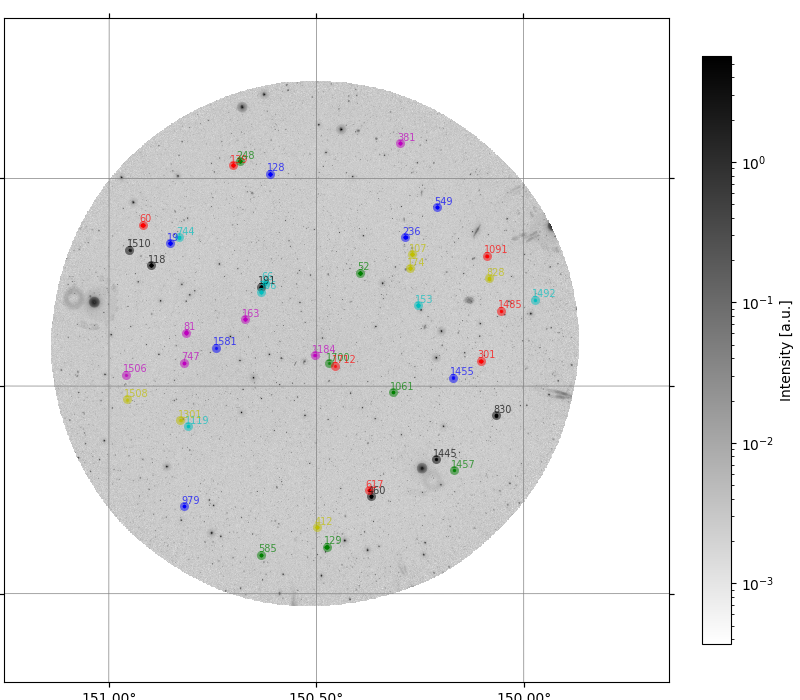

In [4]:
field_id = rg.tt_fields["field_id"][0]
fd = rg.fields[field_id]
fig_sky = vvis.plot_field_sky(fd,plot_detections=True)

Get coverage hp map and plot in sky

<HpxGnomonicAxes: title={'center': 'Nr. of visits'}>

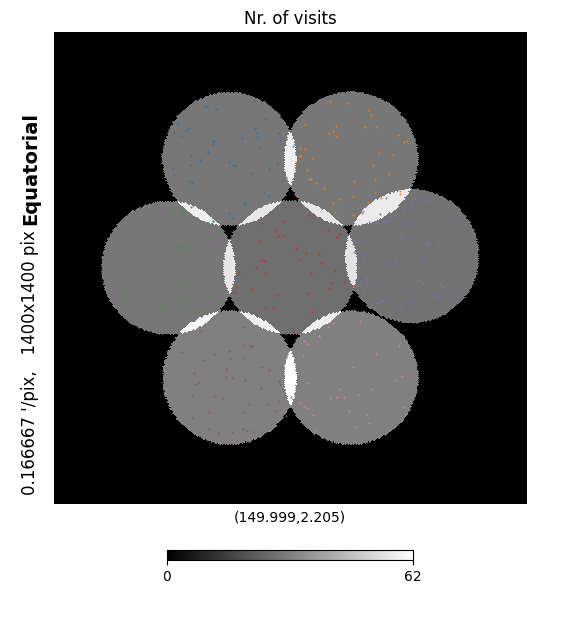

In [5]:
rg.add_coverage_hp(nside=4096)
vvis.plot_region_sky_gnomeview(rg,rg.tt_fields[3]["ra"],rg.tt_fields[3]["dec"])
#write healpix map to Aladin format, modify names
# hpy.fitsfunc.write_map(filename,[hp_vis, hp_exp],coord="C",column_names=["nr_vis", "exposure"],dtype=[np.float32, np.float32],overwrite=True,partial=True)

Plot sky image with Imviz, show source and detection markers on-top

In [6]:
show_imviz = False
if show_imviz:
    hdup = fits.PrimaryHDU(fd.ref_img, header=fd.ref_wcs.to_header())
    imviz = Imviz()
    viewer = imviz.default_viewer
    imviz.load_data(hdup, data_label=str(field_id))
    imviz.show(loc='sidecar')

    sel_det = fd.tt_detections["sel"]
    tt_det_sky = Table({'coord': SkyCoord(fd.tt_detections[sel_det]["ra"], fd.tt_detections[sel_det]["dec"], frame='fk5')})
    viewer.marker = {'color':'blue', 'markersize': 5., 'fill': False} #, 'alpha': 1.0
    viewer.add_markers(tt_det_sky, use_skycoord=True, marker_name='D')

    srcs_sky = SkyCoord(fd.tt_sources["ra"], fd.tt_sources["dec"], frame='fk5')
    tt_srcs_sky = Table({'coord':srcs_sky })
    viewer.marker = {'color':'red', 'markersize': 2., 'fill': True} #, 'alpha': 1.0
    viewer.add_markers(tt_srcs_sky, use_skycoord=True, marker_name='S')

Show field diagnostic plots

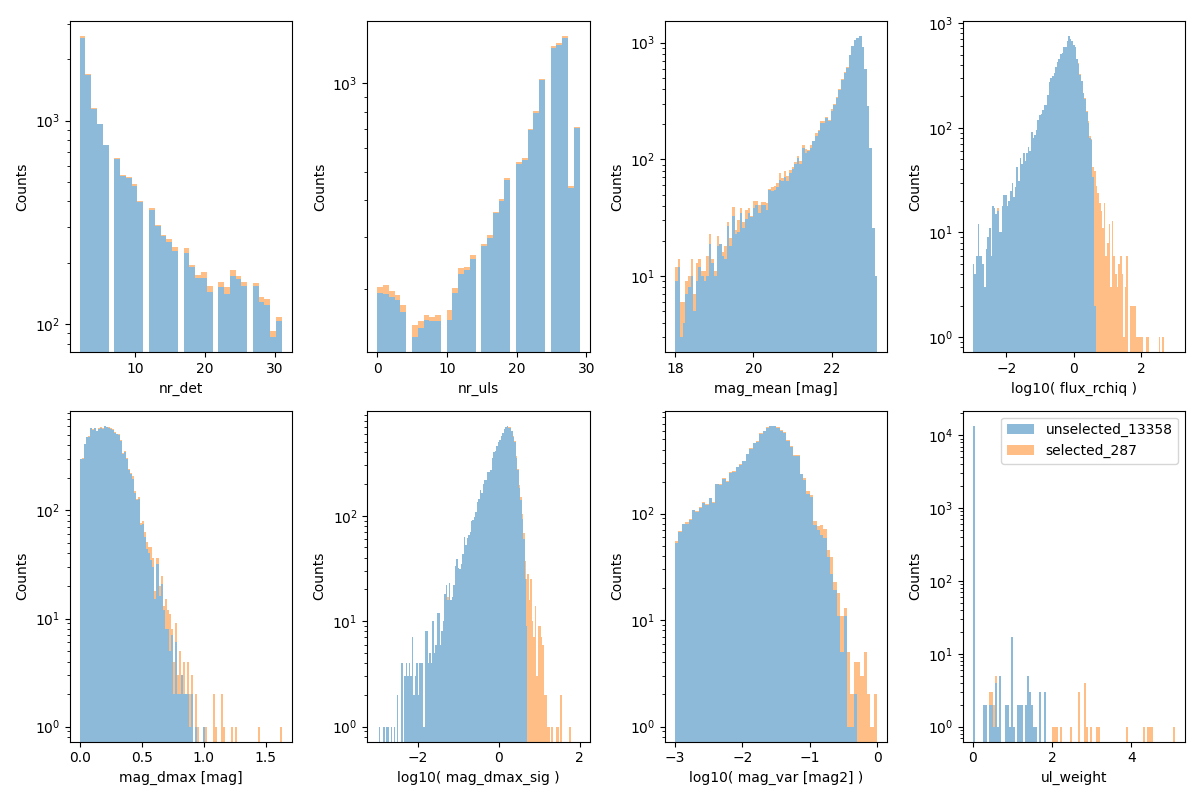

In [7]:
#fig_fd_det_diag_hist = vvis.plot_pipe_diagnostic(fd, "tt_detections", "scatter")
fig_rg_src_diag_scat, plot_pars = vvis.plot_pipe_diagnostic(rg, "tt_sources", "hist")

Look into more details for the chisquare distribution

In [8]:
from astropy import units as uu
fd.set_var_stats()
mag = np.array((fd.ta_sources_lc["mag"].data).tolist())
mag_err = np.array((fd.ta_sources_lc["mag_err"].data).tolist())
print(mag)
flux = (mag*uu.ABmag).physical
flux_err = ((mag - mag_err)*uu.ABmag).physical-flux
print(flux)

[[20.923645 20.796286 20.854029 ... 20.738455 21.060308 20.869501]
 [19.148329 19.192493 19.066366 ... 19.13799   0.       19.191193]
 [20.345442 20.338469 20.359282 ... 20.322966 20.381903 20.318325]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]
[[4.2711203e-09 4.8026969e-09 4.5539488e-09 ... 5.0654436e-09
  3.7659644e-09 4.4895181e-09]
 [2.1911303e-08 2.1037899e-08 2.3629450e-08 ... 2.2120927e-08
  1.0000000e+00 2.1063137e-08]
 [7.2748341e-09 7.3217108e-09 7.1826882e-09 ... 7.4269990e-09
  7.0345858e-09 7.4588211e-09]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]] AB


Comparison of total Nr of events norm, calc: 13392.726450370055 counted: 13307
Table: nr of events, total: 13645 selected: 13645
Min/max rchisq: 2.1441466604708435e-09 422.584915534371


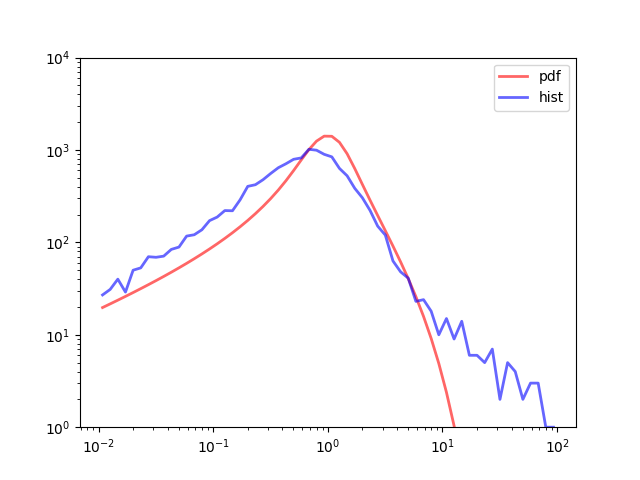

In [14]:
#Setup binning
rchisq_bins_lg = np.linspace(-2, 2, 61)
rchisq_bins = np.power(10,rchisq_bins_lg)
rchisq_bins_mean = (rchisq_bins[:-1]+rchisq_bins[1:])/2.
rchisq_bins_width = rchisq_bins[1:]-rchisq_bins[:-1]

#Select events
sel_det = rg.tt_sources["nr_det"]>1
rg.tt_sources["sel"][:] = sel_det

#Calculate expected rchiq distribution for selected events
rchsq_pdf = np.zeros(len(rchisq_bins_mean))
#Get summed reduced chisquare distribution
for src in rg.tt_sources[sel_det]:
    rchsq_pdf += chi2.pdf(rchisq_bins_mean, src["nr_det"]-1, scale = 1/(src["nr_det"]-1) )*rchisq_bins_width 

rchiq_hist, bins = np.histogram(rg.tt_sources[sel_det]["flux_rchiq"], bins = rchisq_bins)

fig_rchsq = plt.figure()
plt.loglog(rchisq_bins_mean, rchsq_pdf ,'r-', lw=2, alpha=0.6, label='pdf')
plt.loglog(rchisq_bins_mean, rchiq_hist ,'b-', lw=2, alpha=0.6, label='hist')
plt.ylim(1e-0,1e4)
plt.legend()

print("Comparison of total Nr of events norm, calc:",rchsq_pdf.sum(),"counted:",rchiq_hist.sum())
print("Table: nr of events, total:",len(rg.tt_sources),"selected:",rg.tt_sources["sel"].sum())
print("Min/max rchisq:",np.min(rg.tt_sources["flux_rchiq"]),np.max(rg.tt_sources["flux_rchiq"]))